In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
from pathlib import Path
import re
import json

## Annotation DB

### define paths for annotations and audio files

In [2]:
selection_path = Path('../annotations')
recording_path = Path('../../../recordings_2018_filtered')
out_of_water_path = Path('../annotations/out_of_water.json')

filelist = list(selection_path.glob('*selections.txt')) #ignore irrelevent files

### parse .txt file into pandas df

In [3]:
metadata =[]
for file in filelist:
    dfTemp = pd.read_csv(file, sep="\t")
    dfTemp['filename'] = re.search(r'18\d{4,4}_\d{6,6}', file.as_posix()).group() 
    dfTemp['StartMicInWater'] =np.amin(dfTemp['Begin Time (s)'])
    dfTemp['EndMicInWater'] =np.amax(dfTemp['End Time (s)'])
    metadata.append(dfTemp)

metadata = pd.concat(metadata)
metadata.rename(columns={'Begin Time (s)': 'begin_time', 'End Time (s)': 'end_time'}, inplace=True)

### visualize & initial inspection

In [4]:
metadata

,Selection,View,Channel,begin_time,end_time,Low Freq (Hz),High Freq (Hz),Annotation,filename,StartMicInWater,EndMicInWater
0,1,Spectrogram 1,1,192.133141,194.763835,304.572,690.147,un,180914_150127,192.133141,350.807695
1,2,Spectrogram 1,1,221.818444,224.338372,278.651,667.466,w,180914_150127,192.133141,350.807695
2,3,Spectrogram 1,1,235.221136,237.574915,291.612,677.187,w,180914_150127,192.133141,350.807695
3,4,Spectrogram 1,1,235.913424,236.633403,139.326,327.253,un,180914_150127,192.133141,350.807695
4,5,Spectrogram 1,1,236.910319,237.491840,113.404,298.092,un,180914_150127,192.133141,350.807695
...,...,...,...,...,...,...,...,...,...,...,...
720,727,Spectrogram 1,1,1029.697200,1031.592862,163.333,1075.278,NaN,180912_092922,1.402774,1037.676911
721,728,Spectrogram 1,1,1033.488523,1034.128949,272.222,993.611,NaN,180912_092922,1.402774,1037.676911
722,729,Spectrogram 1,1,1035.051164,1035.409802,231.389,666.944,NaN,180912_092922,1.402774,1037.676911
723,730,Spectrogram 1,1,1035.794058,1036.139888,272.222,911.944,NaN,180912_092922,1.402774,1037.676911


In [5]:
print('Number of Labels:', metadata.shape[0])

Number of Labels: 6055


In [6]:
metadata['Annotation'] = metadata['Annotation'].replace(np.nan, 'w', regex=True)
metadata.head()

,Selection,View,Channel,begin_time,end_time,Low Freq (Hz),High Freq (Hz),Annotation,filename,StartMicInWater,EndMicInWater
0,1,Spectrogram 1,1,192.133141,194.763835,304.572,690.147,un,180914_150127,192.133141,350.807695
1,2,Spectrogram 1,1,221.818444,224.338372,278.651,667.466,w,180914_150127,192.133141,350.807695
2,3,Spectrogram 1,1,235.221136,237.574915,291.612,677.187,w,180914_150127,192.133141,350.807695
3,4,Spectrogram 1,1,235.913424,236.633403,139.326,327.253,un,180914_150127,192.133141,350.807695
4,5,Spectrogram 1,1,236.910319,237.491840,113.404,298.092,un,180914_150127,192.133141,350.807695


Text(0.5, 0, 'Label')

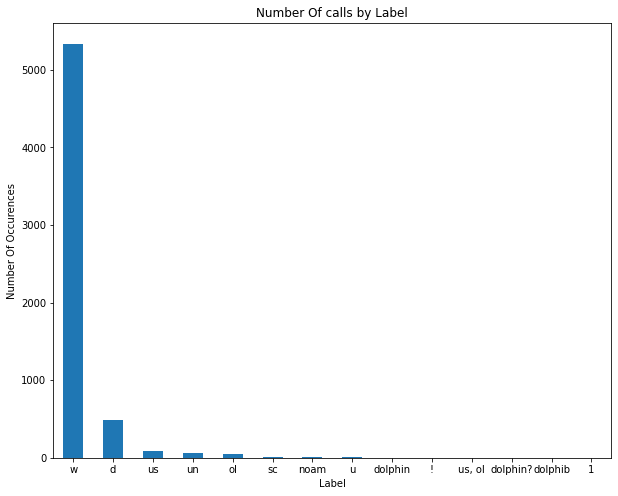

In [7]:
plt.figure(figsize=(10,8))
metadata['Annotation'].value_counts().plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.title('Number Of calls by Label')
plt.ylabel('Number Of Occurences')
plt.xlabel('Label')

## Audio stats

In [8]:
wav_filelist = list(recording_path.glob('*.wav'))

### extract unique audio files with id name

In [9]:
wav_filedict = {re.search(r'18\d{4,4}_\d{6,6}', file.as_posix()).group(): {'path':file} for file in wav_filelist 
            if re.search(r'18\d{4,4}_\d{6,6}', file.as_posix())}

### extract legnths of recordings

In [10]:
for key, value in wav_filedict.items():
    record_length = sf.info(value['path']).duration
    value.update({'length': record_length})
    wav_filedict[key] = value

### Insert duration into main dataframe

In [11]:
annotation_lengths = []
for filename_txt in metadata['filename']:
    annotation_lengths.append(wav_filedict[filename_txt]['length'])
metadata['TotalRecordLength'] = annotation_lengths
metadata.head()

,Selection,View,Channel,begin_time,end_time,Low Freq (Hz),High Freq (Hz),Annotation,filename,StartMicInWater,EndMicInWater,TotalRecordLength
0,1,Spectrogram 1,1,192.133141,194.763835,304.572,690.147,un,180914_150127,192.133141,350.807695,488.806168
1,2,Spectrogram 1,1,221.818444,224.338372,278.651,667.466,w,180914_150127,192.133141,350.807695,488.806168
2,3,Spectrogram 1,1,235.221136,237.574915,291.612,677.187,w,180914_150127,192.133141,350.807695,488.806168
3,4,Spectrogram 1,1,235.913424,236.633403,139.326,327.253,un,180914_150127,192.133141,350.807695,488.806168
4,5,Spectrogram 1,1,236.910319,237.491840,113.404,298.092,un,180914_150127,192.133141,350.807695,488.806168


## Remove noisy/out of water parts from dataset

### load end preprocess out of water parts

In [12]:
def extract_time(input_str: str):
    search_term = re.search(r'(\d):(\d+):(\d+)', input_str)
    if search_term:
        return int(search_term.group(1))*3600 + int(search_term.group(2))*60 + int(search_term.group(3))
    else:
        return input_str

def preprocess_oow_dict(oow_dict: dict): # in place function
    for key, value in oow_dict.items():
        for it, item in enumerate(value):
            item_parts = item.split('-')
            try:
                item_start = extract_time(item_parts[0])
                item_end = extract_time(item_parts[1])
                value[it] = {'start': item_start, 'end': item_end}
            except IndexError:
                value[it] = {}
        oow_dict[key] = value
    
    

In [13]:
with open(out_of_water_path) as json_file:
    out_of_water_dict = json.load(json_file)

In [14]:
# out_of_water_dict
# out_of_water_dict['180919_132511'] = ['0:00:00-0:00:10', '0:02:58-end']
# with open(out_of_water_path, 'w') as json_file:
#     json.dump(out_of_water_dict, json_file)

In [15]:
preprocess_oow_dict(out_of_water_dict)

In [16]:
out_of_water_dict['180912_075945']

[{'start': 0, 'end': 70}, {'start': 493, 'end': 'end'}]

### define filter function based on oow dictionary

In [17]:
def filter_df(df_object, oow_dict):
    for filename in df_object.filename.unique():
        df_object = filter_byfilename(df_object, oow_dict[filename], filename)
    df_object = df_object.reset_index(drop=True)
    return df_object
    
def filter_byfilename(df_object, oow_value, filename):
    if len(oow_value[0]) == 0:
        return df_object
    else:
        for oow_subdict in oow_value:
            df_object = filter_bydict(df_object, oow_subdict, filename)
    return df_object

def filter_bydict(df_object, oow_subdict, filename):
    start = oow_subdict['start']
    if oow_subdict['end'] == 'end':
        end = float("inf")
    else:
        end = oow_subdict['end']
    # edit segments bigger than oow segment
    # Do it iterativly in loop because can contain multiple segments that should split
    condition = ((df_object['filename'] == filename) & (df_object['begin_time'] < start) & 
                 (df_object['end_time'] > end))
    while condition.any():
        add_df = df_object.loc[condition, :].copy()
        add_df.loc[:, 'begin_time'] = end
        df_object.loc[condition, 'end_time'] = start
        df_object.append(add_df, ignore_index=True)
        condition = ((df_object['filename'] == filename) & (df_object['begin_time'] < start) & 
                 (df_object['end_time'] > end))
    # edit segments starting before oow segement
    condition = ((df_object['filename'] == filename) & (df_object['begin_time'] <= start) & 
                 (df_object['end_time'] <= end) & (start < df_object['end_time']))
    df_object.loc[condition, 'end_time'] = start
    # edit segments ending after oow segement
    condition = ((df_object['filename'] == filename) & (df_object['begin_time'] >= start) & 
                 (df_object['end_time'] >= end) & (end > df_object['begin_time']))
    df_object.loc[condition, 'begin_time'] = end
    
    # remove segments inside out of water
    condition = (df_object['filename'] == filename) & (df_object['begin_time'] >= start) & (df_object['end_time'] <= end)
    index_to_drop = df_object[condition].index
    df_object = df_object.drop(index_to_drop)
    return df_object.reset_index(drop=True)

## Segment calls and BG noise

### Calculate total bottom time

In [18]:
y = metadata['TotalRecordLength'] - metadata['EndMicInWater']
assert len(y[y<0]) == 0, "data error, not possible to have 'TotalRecordLength' shorter than 'EndMicInWater'"
z = metadata['StartMicInWater'] 
metadata['TotalBottomTime']  =  metadata['TotalRecordLength'] - (y + z)

In [19]:
metadata.head()

,Selection,View,Channel,begin_time,end_time,Low Freq (Hz),High Freq (Hz),Annotation,filename,StartMicInWater,EndMicInWater,TotalRecordLength,TotalBottomTime
0,1,Spectrogram 1,1,192.133141,194.763835,304.572,690.147,un,180914_150127,192.133141,350.807695,488.806168,158.674554
1,2,Spectrogram 1,1,221.818444,224.338372,278.651,667.466,w,180914_150127,192.133141,350.807695,488.806168,158.674554
2,3,Spectrogram 1,1,235.221136,237.574915,291.612,677.187,w,180914_150127,192.133141,350.807695,488.806168,158.674554
3,4,Spectrogram 1,1,235.913424,236.633403,139.326,327.253,un,180914_150127,192.133141,350.807695,488.806168,158.674554
4,5,Spectrogram 1,1,236.910319,237.491840,113.404,298.092,un,180914_150127,192.133141,350.807695,488.806168,158.674554


In [20]:
metadata['call_length'] = metadata['end_time'] - metadata['begin_time']

### filter metadata to contain only desired call types and remove out of water time

In [21]:
print('Available filters to choose from:')
print(metadata.Annotation.unique())

Available filters to choose from:
['un' 'w' 'us' 'd' 'u' '!' 'noam' 'sc' 'ol' 'us, ol' 'dolphib' 'dolphin'
 'dolphin?' '1']


In [22]:
filters = ['w', 'sc']
metadata_calls = metadata[metadata.Annotation.isin(filters)]

In [23]:
metadata = filter_df(metadata, out_of_water_dict)
metadata_calls = filter_df(metadata_calls, out_of_water_dict)

/home/moshe/PycharmProjects/Deep_Voice/finding_willy/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [24]:
unique_files, idx = np.unique(metadata['filename'], return_index=True)
metadata[['filename', 'TotalBottomTime']].iloc[idx,:]

,filename,TotalBottomTime
3832,180912_073707,46.256880
3425,180912_075945,492.520591
10,180912_083838,1023.597874
4958,180912_092922,1036.274137
3025,180912_155430,182.701526
1758,180914_125804,2598.174167
0,180914_150127,158.674554
1855,180916_112552,402.214646
3871,180917_102412,287.244114
4251,180917_105223,355.973151


### Find true length of call sequences ( get rid of over lapping-sequences)

In [25]:
def merge_calls(sorted_list):
    merged = [sorted_list[0]]
    for higher in sorted_list[1:]:
        lower = merged[-1]
        # test for intersection between lower and higher:
        # we know via sorting that lower[0] <= higher[0]
        if higher[0] <= lower[1]:
            upper_bound = max(lower[1], higher[1])
            merged[-1] = (lower[0], upper_bound)  # replace by merged interval
        else:
            merged.append(higher)
    return merged

def non_overlap_df(input_df):
    non_overlap = []
    for file in unique_files:
        file_df = input_df[input_df['filename'] == file]

        begin = np.array(file_df['begin_time'])
        end = np.array(file_df['end_time'])
        begin_end = np.transpose(np.array((begin, end)))
        sorted_by_lower_bound = sorted(begin_end, key=lambda tup: tup[0])

        merged = merge_calls(sorted_by_lower_bound)

        p = pd.DataFrame({'begin_time':np.array(merged)[:,0], 'end_time':np.array(merged)[:,1] ,'filename':file})
        non_overlap.append(p)
    
    non_overlap = pd.concat(non_overlap)
    non_overlap['call_length'] = non_overlap['end_time'] - non_overlap['begin_time']
    return non_overlap

In [26]:
non_overlap_all = non_overlap_df(metadata)
non_overlap_calls = non_overlap_df(metadata_calls)

# TODO do we want the other calls to be included with the whales for this task? 
# Should filter out desired call types prior overlaps calculations

In [27]:
len(non_overlap_all)

2708

### Label background segments

In [28]:
bg_segments = []
for file in (unique_files):
    file_df = non_overlap_all[non_overlap_all['filename'] == file]
    begin = np.array(file_df['begin_time'])
    end = np.array(file_df['end_time'])
    for item in end:
        next_beginning = begin[begin > item]
        if next_beginning.size == 0:
            break
        next_beginning = np.min(next_beginning)
        bg_segments.append([item , next_beginning, file])
bg_segments=pd.DataFrame(bg_segments, columns=['begin_time' ,'end_time','filename']) 
bg_segments = filter_df(bg_segments, out_of_water_dict)
bg_segments['call_length'] = bg_segments['end_time'] - bg_segments['begin_time']

In [29]:
bg_segments.sort_values(by=['call_length'])

,begin_time,end_time,filename,call_length
2661,246.584449,246.586375,180919_150220,0.001926
1977,147.665496,147.667570,180919_113436,0.002074
2608,79.324311,79.327049,180919_150220,0.002738
2666,254.822838,254.825927,180919_150220,0.003088
2278,79.795666,79.799120,180919_124041,0.003454
...,...,...,...,...
2015,78.596089,96.020051,180919_120105,17.423962
2553,108.602898,131.000000,180919_142548,22.397102
2542,54.831034,83.463241,180919_142548,28.632207
1157,267.900178,314.053771,180914_150127,46.153593


## Stats & Analysis

### View stats

In [30]:
bg_segments['call_length'].mean(),bg_segments['call_length'].var()

(0.8519313966507632, 3.74936486860569)

In [31]:
metadata.groupby('Annotation')['call_length'].mean()

Annotation
!           1.033981
d           0.240564
dolphib     0.262239
dolphin     0.200265
dolphin?    1.631792
ol          3.154107
sc          0.650390
u           0.529915
un          0.660675
us          0.626761
w           0.996478
Name: call_length, dtype: float64

In [32]:
metadata.groupby('Annotation')['call_length'].var()

Annotation
!                NaN
d           0.018099
dolphib          NaN
dolphin     0.002751
dolphin?         NaN
ol          3.223684
sc          0.185698
u           0.335331
un          0.276437
us          0.304853
w           0.536391
Name: call_length, dtype: float64

### Calculate calls density

In [33]:
sum_of_calls = metadata.groupby('filename')['call_length'].sum()
sum_of_calls = pd.DataFrame(sum_of_calls)

In [34]:
unique_files, idx = np.unique(metadata['filename'], return_index=True)
density_df = metadata[['filename', 'TotalBottomTime']].iloc[idx,:]

In [35]:
sum_of_calls_non_overlap = non_overlap_calls.groupby('filename')['call_length'].sum()
sum_of_calls_non_overlap = pd.DataFrame(sum_of_calls_non_overlap)
sum_of_calls_non_overlap = sum_of_calls_non_overlap.rename(columns={'call_length':'SumOfCallsLength'})

In [36]:
sum_of_calls_non_overlap

,SumOfCallsLength
filename,
180912_073707,39.299386
180912_075945,323.654816
180912_083838,894.482474
180912_092922,629.826162
180912_155430,148.862250
180914_125804,53.446810
180914_150127,14.095206
180916_112552,329.252386
180917_102412,161.947722


In [37]:
# DensityDF['TotalBottomTime [sec]'].shape,SumOfCallsNonOverlap['call_length'].shape

In [38]:
density_df['SumOfCalls [sec]'] = np.array(sum_of_calls_non_overlap['SumOfCallsLength'])
# SumOfCallsNonOverlap['SumOfCallsLength']
density_df['Density Of Calls [percentage]'] = np.array(density_df['SumOfCalls [sec]'])/ np.array(density_df['TotalBottomTime'])*100

In [39]:
density_df

,filename,TotalBottomTime,SumOfCalls [sec],Density Of Calls [percentage]
3832,180912_073707,46.256880,39.299386,84.959006
3425,180912_075945,492.520591,323.654816,65.713966
10,180912_083838,1023.597874,894.482474,87.386121
4958,180912_092922,1036.274137,629.826162,60.777949
3025,180912_155430,182.701526,148.862250,81.478384
1758,180914_125804,2598.174167,53.446810,2.057091
0,180914_150127,158.674554,14.095206,8.883092
1855,180916_112552,402.214646,329.252386,81.859870
3871,180917_102412,287.244114,161.947722,56.379823
4251,180917_105223,355.973151,161.528237,45.376522


In [40]:
density_df['Density Of Calls [percentage]'].mean(),density_df['Density Of Calls [percentage]'].std()

(45.08913774851718, 26.267829415096987)

In [41]:
print(" Number Of annotated Files is: " ,len(density_df), "Out Of " ,len(wav_filedict)," Wav Files")

 Number Of annotated Files is:  22 Out Of  43  Wav Files


In [42]:
non_overlap_calls

,begin_time,end_time,filename,call_length
0,0.095199,0.786270,180912_073707,0.691071
1,0.807425,1.241107,180912_073707,0.433682
2,2.221300,2.799544,180912_073707,0.578243
3,2.824225,4.040651,180912_073707,1.216426
4,4.090013,4.414394,180912_073707,0.324380
...,...,...,...,...
97,278.017863,279.293333,180919_150220,1.275469
98,295.690335,297.141447,180919_150220,1.451112
99,298.071014,298.506903,180919_150220,0.435890
100,298.555830,298.747087,180919_150220,0.191258


In [43]:
bg_segments

,begin_time,end_time,filename,call_length
0,1.241107,2.221300,180912_073707,0.980193
1,2.799544,2.824225,180912_073707,0.024681
2,4.040651,4.090013,180912_073707,0.049362
3,4.414394,4.516644,180912_073707,0.102250
4,4.897438,4.927777,180912_073707,0.030338
...,...,...,...,...
2678,277.188688,278.017863,180919_150220,0.829175
2679,279.293333,295.690335,180919_150220,16.397002
2680,297.141447,298.071014,180919_150220,0.929567
2681,298.506903,298.555830,180919_150220,0.048926


## Add labels

In [44]:
bg_segments['label'] = np.zeros(bg_segments.shape[0], dtype=int)
non_overlap_calls['label'] = np.ones(non_overlap_calls.shape[0], dtype=int)

In [45]:
bg_segments.head()

,begin_time,end_time,filename,call_length,label
0,1.241107,2.221300,180912_073707,0.980193,0
1,2.799544,2.824225,180912_073707,0.024681,0
2,4.040651,4.090013,180912_073707,0.049362,0
3,4.414394,4.516644,180912_073707,0.102250,0
4,4.897438,4.927777,180912_073707,0.030338,0


In [46]:
combined_annotations = pd.concat([bg_segments, non_overlap_calls])

## Export Interesting DataFrames


In [47]:
combined_annotations.to_csv('combined_annotations.csv', index=False)